In [1]:
# inspired from: A deep understanding of deep learning


import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split

import sklearn.metrics as skm


import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

# %matplotlib widget
%matplotlib notebook
%matplotlib inline


In [2]:
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')


# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]


# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

In [3]:
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [4]:
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)



    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )

      return self.output(x)




  net = mnistNet()
  
  lossfun = nn.CrossEntropyLoss()

  optimizer = torch.optim.Adam(net.parameters(),lr=.01)




  return net,lossfun,optimizer



In [5]:
def function2trainTheModel():

  numepochs = 10
  
  net,lossfun,optimizer = createTheMNISTNet()

  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  for epochi in range(numepochs):

    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      yHat = net(X)
      loss = lossfun(yHat,y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchLoss.append(loss.item())

      matches = torch.argmax(yHat,axis=1) == y
      matchesNumeric = matches.float()
      accuracyPct = 100*torch.mean(matchesNumeric)
      batchAcc.append( accuracyPct )



    trainAcc.append( np.mean(batchAcc) )

    losses[epochi] = np.mean(batchLoss)

    X,y = next(iter(test_loader))
    with torch.no_grad():
      yHat = net(X)
      

    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )




  return trainAcc,testAcc,losses,net



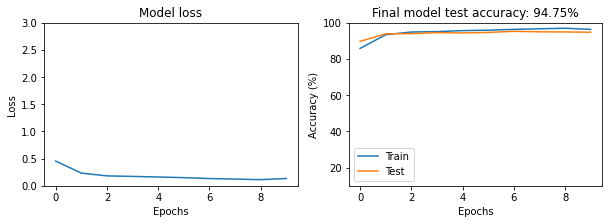

In [6]:
trainAcc,testAcc,losses,net = function2trainTheModel()


fig,ax = plt.subplots(1,2,figsize=(10,3))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [7]:
yHat = net(train_loader.dataset.tensors[0])
train_predictions = torch.argmax(yHat,axis=1)

yHat = net(test_loader.dataset.tensors[0])
test_predictions = torch.argmax(yHat,axis=1)
test_predictions

tensor([4, 2, 0,  ..., 3, 0, 5])

In [8]:
# on computing precision in multiclass data:
#   There are now 10 classes, so there are 10 precision values.


## option 1: compute precision for each class (each number)
skm.precision_score(train_loader.dataset.tensors[1],train_predictions,average=None)

## option 2: compute average precision, weighted by N
skm.precision_score(train_loader.dataset.tensors[1],train_predictions,average='weighted')

## option 3: compute average precision, unweighted (same as 'weighted' if category N's are equal)
skm.precision_score(train_loader.dataset.tensors[1],train_predictions,average='macro')



0.9720684110757543

In [9]:
train_metrics = [0,0,0,0]
test_metrics  = [0,0,0,0]

train_metrics[0] = skm.accuracy_score (train_loader.dataset.tensors[1],train_predictions) # accuracy is overall
train_metrics[1] = skm.precision_score(train_loader.dataset.tensors[1],train_predictions,average='weighted')
train_metrics[2] = skm.recall_score   (train_loader.dataset.tensors[1],train_predictions,average='weighted')
train_metrics[3] = skm.f1_score       (train_loader.dataset.tensors[1],train_predictions,average='weighted')


test_metrics[0] = skm.accuracy_score (test_loader.dataset.tensors[1],test_predictions)
test_metrics[1] = skm.precision_score(test_loader.dataset.tensors[1],test_predictions,average='weighted')
test_metrics[2] = skm.recall_score   (test_loader.dataset.tensors[1],test_predictions,average='weighted')
test_metrics[3] = skm.f1_score       (test_loader.dataset.tensors[1],test_predictions,average='weighted')

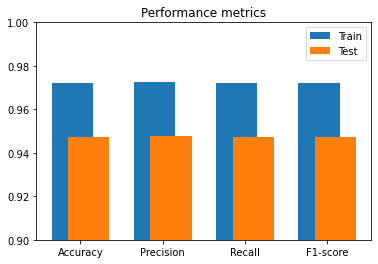

In [10]:
plt.bar(np.arange(4)-.1,train_metrics,.5)
plt.bar(np.arange(4)+.1,test_metrics,.5)
plt.xticks([0,1,2,3],['Accuracy','Precision','Recall','F1-score'])
plt.ylim([.9,1])
plt.legend(['Train','Test'])
plt.title('Performance metrics')
plt.show()

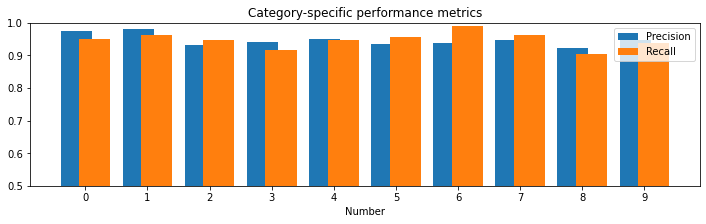

In [11]:
# Bar graphs of class-specific precision and recall for test data

precision = skm.precision_score(test_loader.dataset.tensors[1],test_predictions,average=None)
recall    = skm.recall_score   (test_loader.dataset.tensors[1],test_predictions,average=None)


fig = plt.figure(figsize=(12,3))
plt.bar(np.arange(10)-.15,precision,.5)
plt.bar(np.arange(10)+.15,recall,.5)
plt.xticks(range(10),range(10))
plt.ylim([.5,1])
plt.xlabel('Number')
plt.legend(['Precision','Recall'])
plt.title('Category-specific performance metrics')
plt.show()

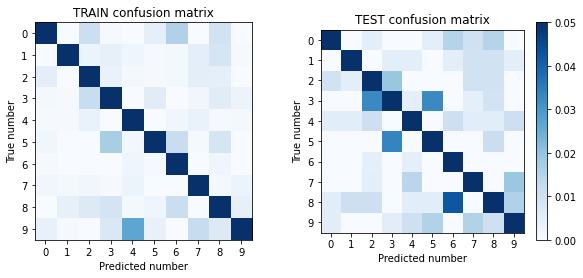

In [12]:
trainConf = skm.confusion_matrix(train_loader.dataset.tensors[1],train_predictions,normalize='true')
testConf  = skm.confusion_matrix(test_loader.dataset.tensors[1], test_predictions,normalize='true')

fig,ax = plt.subplots(1,2,figsize=(10,4))

ax[0].imshow(trainConf,'Blues',vmax=.05)
ax[0].set_xticks(range(10))
ax[0].set_yticks(range(10))
ax[0].set_title('TRAIN confusion matrix')
ax[0].set_xlabel('True number')
ax[0].set_xlabel('Predicted number')
ax[0].set_ylabel('True number')

a = ax[1].imshow(testConf,cmap='Blues',vmax=.05)
ax[1].set_xticks(range(10))
ax[1].set_yticks(range(10))
ax[1].set_title('TEST confusion matrix')
ax[1].set_xlabel('Predicted number')
ax[1].set_ylabel('True number')

fig.colorbar(a)
plt.show()